# Missing Annotation Detection

[![Jupyter Notebook](https://img.shields.io/badge/jupyter-%23FA0F00.svg?style=for-the-badge&logo=jupyter&logoColor=white)](https://github.com/openvinotoolkit/datumaro/blob/develop/notebooks/16_missing_annotation_detection.ipynb)

This tutorial covers how to identify missing annotations in datasets. Currently, it only supports the bounding box annotation type, so that the dataset for object detection tasks can benefit from this feature. it utilizes both [Datumaro](https://github.com/openvinotoolkit/datumaro) and [OpenVINO™ Training Extensions](https://github.com/openvinotoolkit/training_extensions) simultaneously. The reason for this is that it requires a trained model for the dataset in order to identify missing annotations.

## Prerequisite
### Download Six-sided Dice dataset
This is [a download link for Six-sided Dice dataset in Kaggle](https://www.kaggle.com/datasets/nellbyler/d6-dice?resource=download). Please download using this link and extract to your workspace directory. Then, you will have a `d6-dice` directory with annotations and images in YOLO format as follows.

```bash
d6-dice
├── Annotations
│   ├── classes.txt
│   ├── IMG_20191208_111228.txt
│   ├── IMG_20191208_111246.txt
│   ├── ...
└── Images
    ├── IMG_20191208_111228.jpg
    ├── IMG_20191208_111246.jpg
    ├── ...
```

However, for import compatibility, `obj.names` file must be added to `d6-dice/obj.names` filepath for import compatibility. This `obj.names` file includes the label names of the dataset, e.g., `[dice1, ..., dice6]`. Therefore, you can write it with the following simple code. Please see [Yolo Loose format](https://openvinotoolkit.github.io/datumaro/latest/docs/explanation/formats/yolo) for more details.

In [ ]:
# Copyright (C) 2023 Intel Corporation
#
# SPDX-License-Identifier: MIT

import os

root_dir = "d6-dice"

names = """
dice1
dice2
dice3
dice4
dice5
dice6
"""

fpath = os.path.join(root_dir, "obj.names")
with open(fpath, "w") as fp:
    fp.write(names)

### Install OpenVINO™ Training Extensions
For more details, please see this [OpenVINO™ Training Extensions installation guide](https://openvinotoolkit.github.io/training_extensions/latest/guide/get_started/quick_start_guide/installation.html).

In [ ]:
!pip install otx

## Synthesize missing annotation using Datumaro Python API

In this section, we utilize the Datumaro Python API to synthesize missing annotations from the dataset. We import the d6-dice dataset and apply dataset transforms for subsequent stages. Initially, we divide the dataset into three subsets: train, val, and test for model training.

In [54]:
import datumaro as dm

dataset = dm.Dataset.import_from("d6-dice", format="yolo")
dataset.transform("random_split", splits=[("train", 0.5), ("val", 0.2), ("test", 0.3)])
dataset

Dataset
	size=250
	source_path=d6-dice
	media_type=<class 'datumaro.components.media.Image'>
	annotated_items_count=250
	annotations_count=1795
subsets
	test: # of items=75, # of annotated items=75, # of annotations=549, annotation types=['bbox']
	train: # of items=125, # of annotated items=125, # of annotations=897, annotation types=['bbox']
	val: # of items=50, # of annotated items=50, # of annotations=349, annotation types=['bbox']
infos
	categories
	label: ['dice1', 'dice2', 'dice3', 'dice4', 'dice5', 'dice6']

### Synthesize Missing Annotations

We synthesize 4 training samples to have missing annotations. We randomly pick 4 samples from the training subset. If each item has `k` bounding boxes, we sample `k - 1` bounding boxes and drop one bounding box as missing annotation. You can see that one bounding box for each item is missed in the following visualization.

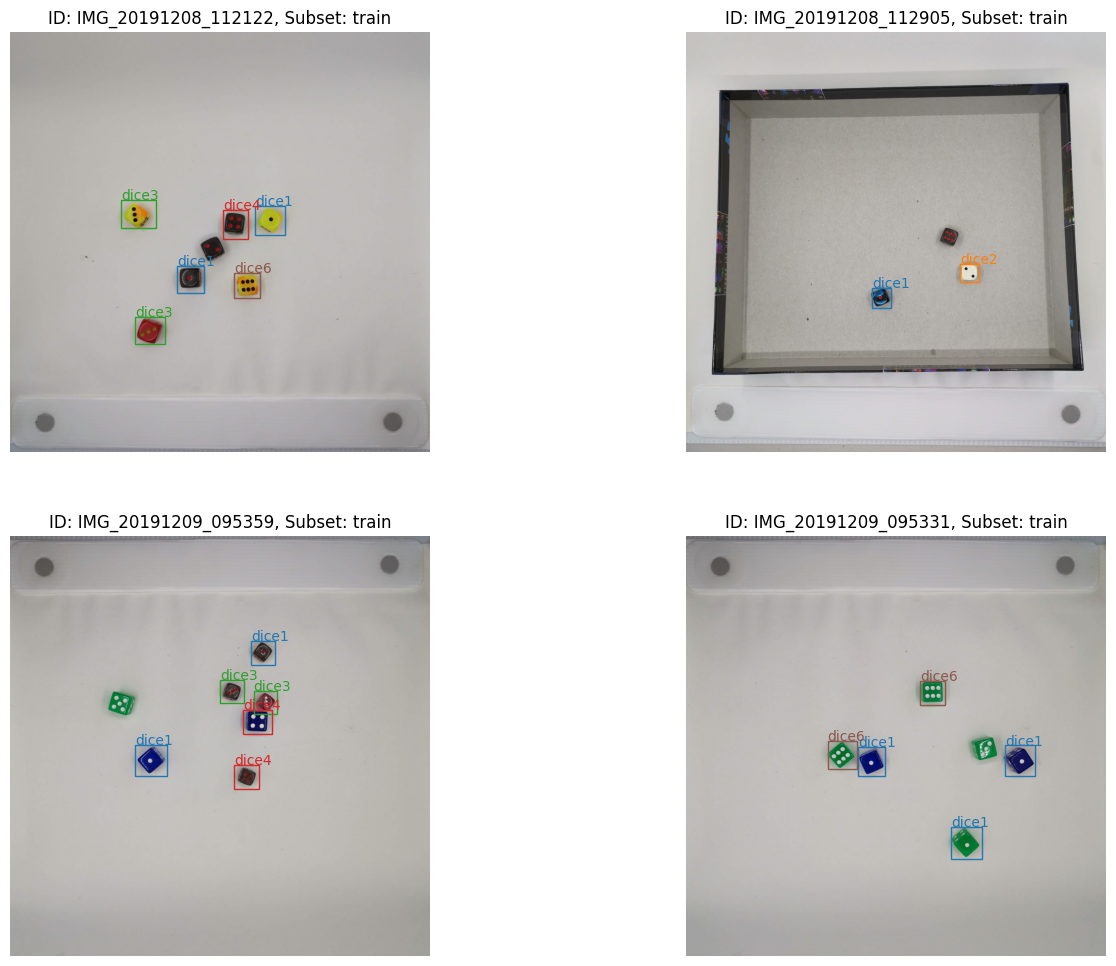

In [55]:
import random

random.seed(3003)

n_missing_anns = 4
label_categories = dataset.categories()[dm.AnnotationType.label]
training_items = [item for item in dataset if item.subset == "train"]

random.shuffle(training_items)

missing_anns_item_ids = []

for item in training_items[:n_missing_anns]:
    k = len(item.annotations) - 1
    item.annotations = random.sample(item.annotations, k=k)
    missing_anns_item_ids += [item.id]

viz = dm.Visualizer(dataset, figsize=(16, 12))
fig = viz.vis_gallery(missing_anns_item_ids, "train")
fig.show()

We export this synthesized missing annotation dataset to train the model with OpenVINO™ Training Extensions.

In [56]:
dataset.export("d6-dice-missing", format="datumaro_binary", save_media=True)

### Train a Model and Export the Trained Detection Model Using OpenVINO™ Training Extensions

In this step, we train a detection model using OpenVINO™ Training Extensions. To see the detail guides for OpenVINO™ Training Extensions usage, please see [How-To-Train](https://openvinotoolkit.github.io/training_extensions/latest/guide/tutorials/base/how_to_train/classification.html). In this example, we use the CLI command to train the model and export it to OpenVINO™ Intermediate Representation (IR). To use the model inference launcher in Datumaro, you should convert your model to OpenVINO™ IR. In this example, we choose `Custom_Object_Detection_Gen3_ATSS` model supported by OpenVINO™ Training Extensions.

In [ ]:
!otx train Custom_Object_Detection_Gen3_ATSS \
    --train-data-roots d6-dice-noisy \
    --val-data-roots d6-dice-noisy \
    -o outputs
!otx export Custom_Object_Detection_Gen3_ATSS \
    --load-weights outputs/models/weights.pth \
    -o outputs

### Importing the Trained Detection Model

In this step, we import the trained detection model and initiate model inference to obtain the predicted bounding boxes. The `OpenvinoLauncher` class is used, which requires the paths to the exported OpenVINO™ IR files and the path for the model interpreter, or the model name. Generally, `OpenvinoLauncher` requires the following arguments:

1) The `description` argument requires the XML file path that represents the model description.
2) The `weights` argument is the binary file path that includes the model weights.
3) The `interpreter` argument is the path to the Python source code file (`*.py`) that defines the model interpreter. The model interpreter contains Python code for pre-processing and post-processing model inputs and outputs.
4) (Optional) The `model_name` argument can be used to load a pre-defined model interpreter from Datumaro. Since `Custom_Object_Detection_Gen3_ATSS` is supported by OpenVINO™ Training Extensions, Datumaro already includes the [pre-defined model interpreter](https://github.com/openvinotoolkit/datumaro/blob/develop/src/datumaro/plugins/openvino_plugin/samples/otx_custom_object_detection_gen3_atss_interp.py) in its package. Therefore, by providing `model_name` in the [Datumaro OpenVINO™ samples](https://github.com/openvinotoolkit/datumaro/blob/develop/src/datumaro/plugins/openvino_plugin/samples), you do not need to implement you own model interpreter and omit `interpreter` argument.

In [66]:
from datumaro.plugins.openvino_plugin.launcher import OpenvinoLauncher

launcher = OpenvinoLauncher(
    description="outputs/openvino.xml",
    weights="outputs/openvino.bin",
    model_name="otx_custom_object_detection_gen3_atss",
)

### Execute MissingAnnotationDetection Transform

To identify missing annotations, you need to execute `MissingAnnotationDetection` transform on your dataset. It requires the `launcher` that we previously loaded from the OpenVINO™ IR. Additionally, there are two configuration parameters to control the behavior of the algorithm:

1) The `pairwise_dist` parameter specifies the distance metric used to measure the distance between two annotations (ground-truth annotation and model prediction). Typically, the distance metric used is Intersection over Union (IoU), which is bounded between 0 and 1. In this example, we used a value of 0.7, so that all predicted bounding boxes with an IoU greater than 0.7 with the ground-truth bounding boxes will be excluded from the outputs of the transform.

2) The `score_threshold` parameter is the minimum score required for an annotation to be considered a candidate for missing annotations. Usually, the model prediction includes confidence scores for its outputs. In Datumaro, the confidence value of a model output is stored in the `attribute` field of the annotation with the `score` key. In this example, we set `score_threshold` as 0.35, meaning that all bounding boxes with a score less than 0.35 will be excluded from the outputs of the transform.

In [ ]:
from datumaro.plugins.missing_annotation_detection import MissingAnnotationDetection

dataset = dm.Dataset.import_from("d6-dice-missing", format="datumaro_binary")

with dm.eager_mode():
    dataset.transform(
        MissingAnnotationDetection,
        launcher=launcher,
        pairwise_dist=0.7,
        score_threshold=0.35,
    )

As you can see in the following visualization of the `MissingAnnotationDetection` outputs, it succeeds to find the missing annotations which we synthesized in the previous step.

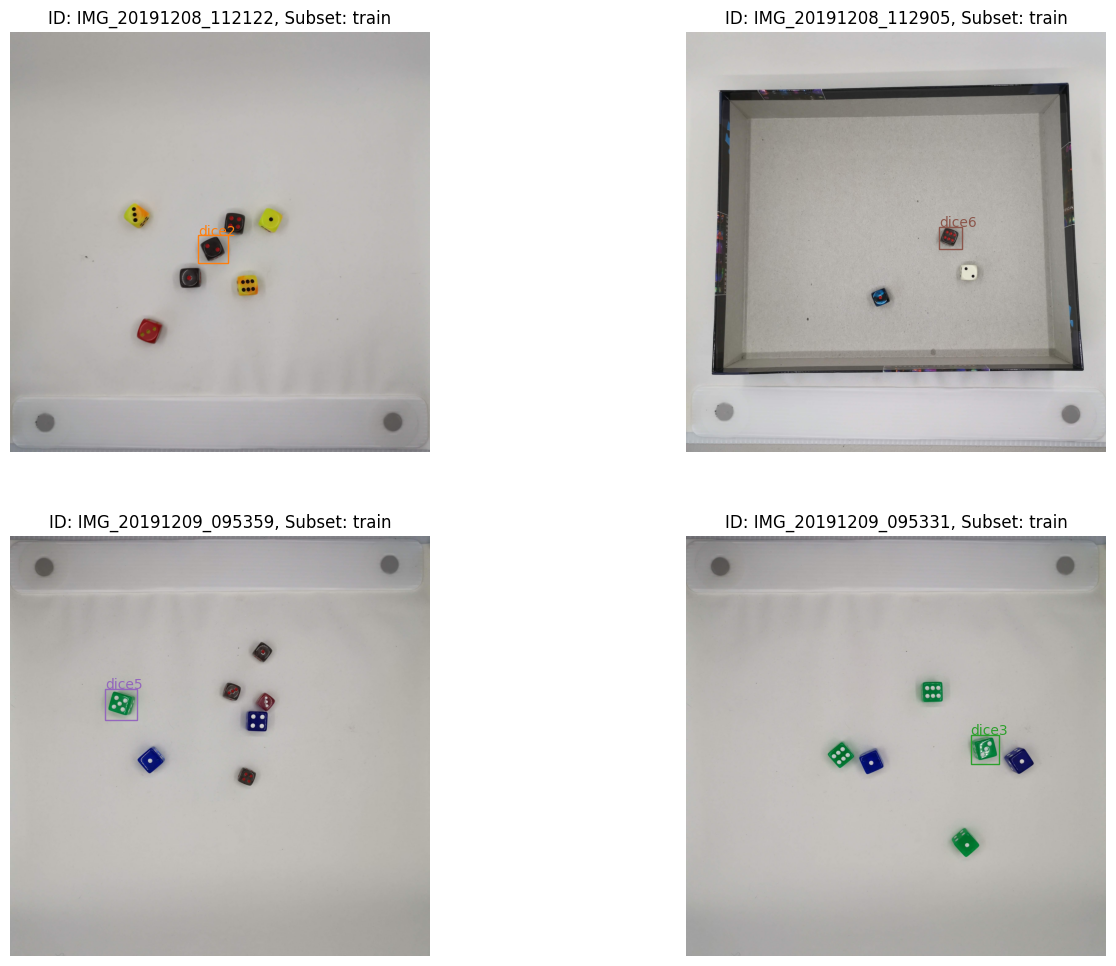

In [70]:
viz = dm.Visualizer(dataset, figsize=(16, 12))
fig = viz.vis_gallery(missing_anns_item_ids, "train")
fig.show()

### Merge the Missing Annotations with the Source Dataset

Having successfully identified the missing annotations in the dataset, the next step is to merge these annotations with the source dataset.
This can be achieved using the `intersect` merge strategy provided by Datumaro.
The `intersect` strategy combines two sets of annotations belonging to images that exist in both datasets.
The merging process involves selecting annotations that do not have spatial overlaps between the two sets.
By applying the `intersect` merge strategy, we obtain a unified dataset that includes the images with the merged annotations.

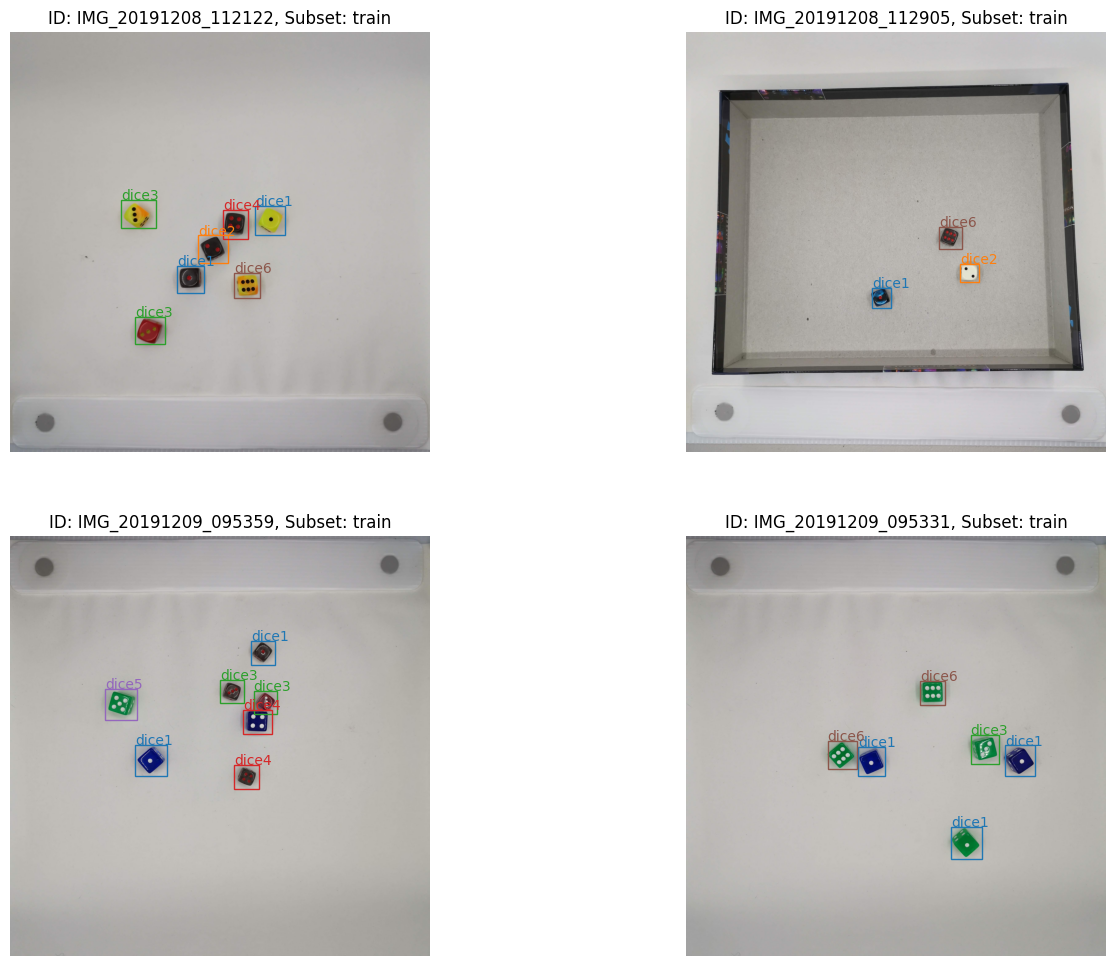

In [73]:
src_dataset = dm.Dataset.import_from("d6-dice-missing", format="datumaro_binary")
merged = dm.HLOps.merge(dataset, src_dataset, merge_policy="intersect")

viz = dm.Visualizer(merged, figsize=(16, 12))
fig = viz.vis_gallery(missing_anns_item_ids, "train")
fig.show()

You can also export the merged dataset with the data format you want as follows.

In [74]:
merged.export("d6-dice-found-missing-anns", format="coco_instances", save_media=True)